In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from gurobipy import *

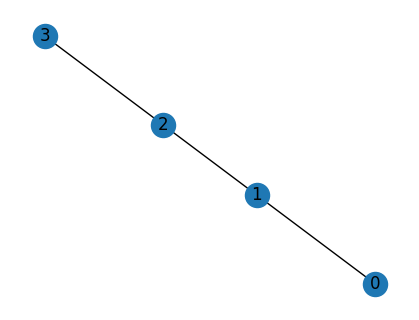

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 21 rows, 36 columns and 56 nonzeros
Model fingerprint: 0x111d34ae
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [2e-01, 2e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 2e+02]
Presolve removed 16 rows and 28 columns
Presolve time: 0.00s
Presolved: 5 rows, 8 columns, 22 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+30   3.500000e+30   1.000000e+00      0s
       4    3.3333333e+01   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.333333333e+01


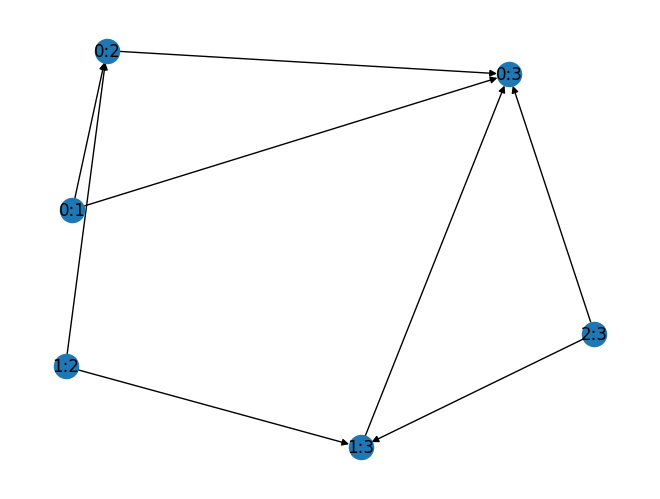

In [166]:
N = 4# number of nodes
G = nx.Graph()
G.add_nodes_from(np.arange(N))
p = 100
q = 0.5
# adj_mat = np.diag(np.ones(N-1),1)
adj_mat = np.zeros((N,N))
for n in range(N-1):
    adj_mat[n,n+1] = p
adj_mat[1,2] = 200
# adj_mat[0,2] = p
# adj_mat[1,2] = p
# adj_mat[2,3] = 200
# adj_mat[3,4] = p
# adj_mat[3,5] = p
adj_mat += adj_mat.T
G = nx.from_numpy_array(adj_mat)
# G.add_edges_from([(q,q+1) for q in range(N-1)])
plt.figure(figsize=(4,3))
nx.draw(G,  with_labels=True)
plt.show()

Eflow_sol = nx.DiGraph()
for n1 in range(N):
    for n2 in range(n1+1,N):
        Eflow_sol.add_node("%d:%d" % (n1,n2))
        
# indices: (superscript, subscript)
m = Model()
Ef_size = int(N*(N-1)/2)
f = m.addMVar((Ef_size,Ef_size), vtype=GRB.CONTINUOUS,name="f")

Ef_nodes = np.array(list(Eflow_sol.nodes()))
s = "0"
t = "%d" % (N-1)
# t = "4"
st1 = np.argwhere(Ef_nodes== s+":"+t ) [0][0]
s = "1"
t = "5"
# st2 = np.argwhere(Ef_nodes== s+":"+t ) [0][0]
st = np.array([st1])

Ist = 0
for n1 in range(N):
    for n2 in range(n1+1,N):
        
        ab = np.argwhere(Ef_nodes== "%d:%d" % (n1,n2) ) [0][0]
        if ab in st:    
            for n3 in range(N):
                if n3 not in [n1,n2]:
                    ac = np.argwhere(Ef_nodes== "%d:%d" % (min(n1,n3), max(n1,n3)) ) [0][0]
                    bc = np.argwhere(Ef_nodes== "%d:%d" % (min(n2,n3), max(n2,n3)) ) [0][0]
                    Ist += q*(f[ac][ab]+f[bc][ab])/2
                    m.addConstr( f[ac][ab]==f[bc][ab] ) 
                    if ac in st or bc in st:
                        m.addConstr( f[bc][ab]==0 ) 
                        m.addConstr( f[ac][ab]==0 )                     
        else:
            lhs = adj_mat[n1,n2]
            rhs = 0
            for n3 in range(N):
                if n3 not in [n1,n2]:
                    ac = np.argwhere(Ef_nodes== "%d:%d" % (min(n1,n3), max(n1,n3)) ) [0][0]
                    bc = np.argwhere(Ef_nodes== "%d:%d" % (min(n2,n3), max(n2,n3)) ) [0][0]
                    rhs += f[ab][ac]+f[ab][bc]
                    
                    if ac in st or bc in st:
                        m.addConstr( f[bc][ab]==0 ) 
                        m.addConstr( f[ac][ab]==0 ) 
                    else:
                        m.addConstr( f[ac][ab]==f[bc][ab] ) 
                        lhs += q*(f[ac][ab]+f[bc][ab])/2
                    
            m.addConstr(lhs >= rhs ) 
        
m.setObjective(Ist , GRB.MAXIMIZE)
m.optimize()

        
f_opt = np.zeros((Ef_size,Ef_size))
for i in range(Ef_size):
    for j in range(Ef_size):
        if m.getVars()[i*Ef_size+j].X > 0:
            f_opt[i,j] = m.getVars()[i*Ef_size+j].X
            Eflow_sol.add_edge(Ef_nodes[i],Ef_nodes[j])

nx.draw(Eflow_sol,  with_labels=True)
plt.show()


In [82]:
ab_ind = st[0]
Eflow = nx.DiGraph()
for n1 in range(N):
    for n2 in range(n1+1,N):
        Eflow.add_node("%d:%d" % (n1,n2))

def decompose(f_opt,ab_ind):
    inds = list(np.argwhere(f_opt[:,ab_ind]>0)[:,0])
    if len(inds)>0:
        for i in [inds[0]]:
#             if ab_ind == st[0]:
#                 print("=======")
#                 if len(Eflow.edges)>0:
#                     plt.figure(figsize=(20,20))
#                     nx.draw(Eflow,  with_labels=True)
# #                     components = [Eflow.subgraph(c1).copy() for c1 in nx.connected_components(Eflow)]
# #                     nx.draw(components[0],  with_labels=True)
#                     plt.show()
#                 Eflow.remove_edges_from(list(Eflow.edges))
                
                        
            ab = list(map(int, Ef_nodes[ab_ind].split(":")))
            ac = list(map(int, Ef_nodes[i].split(":")))
            b = list(set(ab)-set(ac))[0]
            c = list(set(ac)-set(ab))[0]
            bc_ind = np.argwhere(Ef_nodes== "%d:%d" % (min(b,c), max(b,c)) ) [0][0]
            bc = list(map(int, Ef_nodes[bc_ind].split(":")))
            a = list(set(ac)-set(bc))[0]
            ac_ind = np.argwhere(Ef_nodes== "%d:%d" % (min(a,c), max(a,c)) ) [0][0]
            inds.remove(bc_ind)
#             Eflow.add_edge(Ef_nodes[ac_ind],Ef_nodes[ab_ind])
#             Eflow.add_edge(Ef_nodes[bc_ind],Ef_nodes[ab_ind])
            print(ab,ac,bc)
            decompose(f_opt,bc_ind)
            decompose(f_opt,ac_ind)
    else:
        ab = list(map(int, Ef_nodes[ab_ind].split(":")))
        print(ab,"end node")

decompose(f_opt,st[0])
# plt.figure(figsize=(20,20))
# nx.draw(Eflow,  with_labels=True)
# # components = [Eflow.subgraph(c1).copy() for c1 in nx.connected_components(Eflow)]
# # nx.draw(components[0],  with_labels=True)
# plt.show()
                

[0, 7] [0, 3] [3, 7]
[3, 7] [3, 5] [5, 7]
[5, 7] [5, 6] [6, 7]
[6, 7] end node
[5, 6] end node
[3, 5] [3, 4] [4, 5]
[4, 5] end node
[3, 4] end node
[0, 3] [0, 1] [1, 3]
[1, 3] [1, 2] [2, 3]
[2, 3] end node
[1, 2] end node
[0, 1] end node


In [40]:
ab_ind = st[0]
pflows_set = []
layer_inds = set(inds.copy())
remaining_inds = list(set(range(Ef_size))-set(inds))
inds = list(np.argwhere(f_opt[:,ab_ind]>0)[:,0])
# for ac_ind in inds:
def ef_in(G,v):
    inds = []
    for e in G.predecessors(v):
        inds.append(e)
    return inds

def ef_out(G,v):
    inds = []
    for e in G.successors(v):
        inds.append(e)
    return inds


while len(inds)>0:
    pflow = Eflow_sol.copy()
#     nx.draw(pflow,  with_labels=True)
#     plt.show()
    ab = list(map(int, Ef_nodes[ab_ind].split(":")))
    ac = list(map(int, Ef_nodes[ac_ind].split(":")))
    b = list(set(ab)-set(ac))[0]
    c = list(set(ac)-set(ab))[0]
    bc_ind = np.argwhere(Ef_nodes== "%d:%d" % (min(b,c), max(b,c)) ) [0][0]
    bc = list(map(int, Ef_nodes[bc_ind].split(":")))
    a = list(set(ac)-set(bc))[0]
    ac_ind = np.argwhere(Ef_nodes== "%d:%d" % (min(a,c), max(a,c)) ) [0][0]
    inds.remove(ac_ind)
    inds.remove(bc_ind)
#     nodes_to_remove = list(Eflow_sol.nodes())
    print(ab,ac,bc)
    print(Ef_nodes[list(layer_inds-{ac_ind,bc_ind})])
    for edge_ind in Ef_nodes[list(layer_inds-{ac_ind,bc_ind})]:
        print(pflow.successor(edge_ind))
        if len(list(pflow.successor(edge_ind)))==1:
            pflow.remove_node(edge_ind)
        else:
            pflow.remove_edge(edge_ind,Ef_nodes[ab_ind])

#     pflow.remove_nodes_from(Ef_nodes[list(layer_inds-{ac_ind,bc_ind})])
    nx.draw(pflow,  with_labels=True)
    plt.show()


[0, 3] [0, 1] [1, 3]
['0:2' '2:3']


AttributeError: 'DiGraph' object has no attribute 'successor'

In [160]:
def ef_in(G,v):
    inds = []
    for e in G.predecessors(v):
        inds.append(e)
    return inds

def ef_out(G,v):
    inds = []
    for e in G.successors(v):
        inds.append(e)
    return inds

ab_ind = st[0]
pflows_set = []
layer_inds = set(inds.copy())
remaining_inds = list(set(range(Ef_size))-set(inds))
inds = list(np.argwhere(f_opt[:,ab_ind]>0)[:,0])

def decompose(G,ab):
    e_in_set = ef_in(G,ab)
    if len(e_in_set)>1:
        G_tree = []
        remain = list( set(G.nodes())- {ab} )
        G0 = nx.DiGraph()
        G0.add_node(ab)
        subG = (nx.subgraph(G,remain)).copy()
        for ac in e_in_set:
            b = list(set(map(int, ab.split(":")))-set(map(int, ac.split(":"))))[0]
            c = list(set(map(int, ac.split(":")))-set(map(int, ab.split(":"))))[0]            
            bc = "%d:%d" % (min(b,c), max(b,c))             
#             print(ab,ac,bc)
#             remain_ac = list( set(G.nodes())- set(e_in_set + [ab]) ) +[ac]
#             print(remain_ac)
#             nx.draw(subG_ac,  with_labels=True)
#             plt.show()
            subG_ac = decompose(subG,ac)
            subG_bc = decompose(subG,bc)
            
            for G_ac in subG_ac:
                G_new_ac = nx.compose(G0,G_ac)
                G_new_ac.add_edge(ac,ab)
                for G_bc in subG_bc:
                    G_new = nx.compose(G_new_ac,G_bc)
                    G_new.add_edge(bc,ab)
                    G_tree.append(G_new)

        
#             remain_bc = list( set(G.nodes())- set(e_in_set + [ab]) ) +[bc]
#             print(remain_bc)
#             subG_bc = nx.subgraph(G,remain_bc)
# #             nx.draw(subG_bc,  with_labels=True)
# #             plt.show()
#             decompose(subG_bc,bc)
#             G_tree.append(G1)
            e_in_set.remove(bc)
#             decompose(f_opt,bc_ind)
#             decompose(f_opt,ac_ind)
        return G_tree
    else:
#         print(ab, "no edge")
        G1 = G.copy()
        for e_out in ef_out(G1,ab):
            G1.remove_node(e_out)
#         for e_in in ef_in(G1,ab):
#             G1.remove_node(e_in)
#         G_out = nx.node_connected_component(G1, ab)
        subG1 = nx.subgraph(G1,e_in_set+[ab])
#         print(subG1.nodes())
        return [subG1]
                

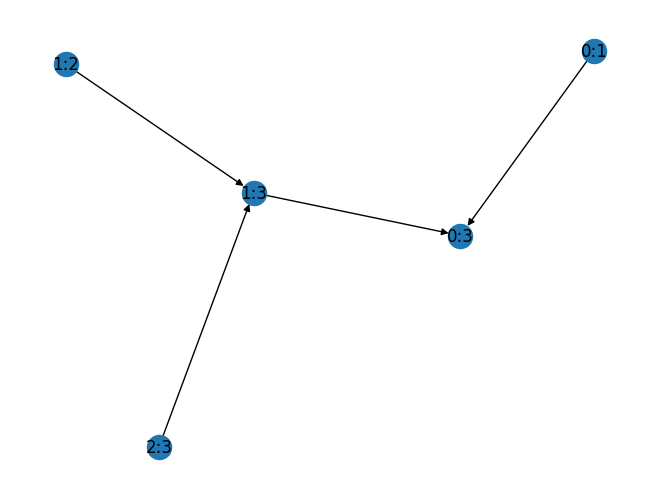

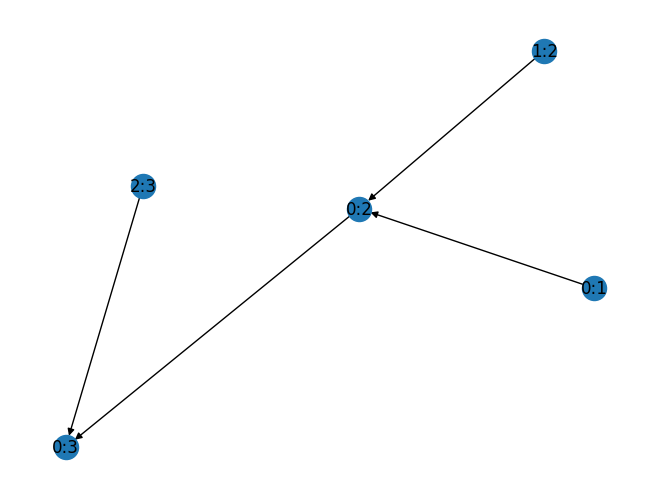

In [162]:
for G in decompose(Eflow_sol, "0:3"):
    nx.draw(G,  with_labels=True)
    plt.show()
    
# for G in decompose(Eflow_sol, "1:5"):
#     nx.draw(G,  with_labels=True)
#     plt.show()

In [71]:
[1,2]-[3,4]

TypeError: unsupported operand type(s) for -: 'list' and 'list'